This notebook explores and validates a geometric-based approach to constraining the prior for the Bayesian model.


# Simplest geometric consideration: $A_c < A$

By definition, the percentile threshold $P$ will select $N_c = (1-P) \cdot N_T$ points out of the total $N_T$ points in the input field.  If we approximate the area of all individual grid cells (ignoring the latitudinal dependence) as $\overline{A}$, then the total area of cells above the percentile threshold will be $A_c = \overline{A} N_T (1-P)$.

Simple logic then dictates that in order for any AR to be detected, the area of selected grid cells must be as large or larger than the minimum-area threshold $A$ for contiguous blobs above the percentile threshold: i.e., if $A_c < A$, then no AR detections are possible.  I argue that the prior should be constrained to be 0 in regions meeting this condition.  This condition effectively defines a 'dead-line' in P-A space, where the prior is 0 to the right of the dead-line:

$$ A = \overline{A} N_T (1-P) $$

In [1]:
""" Initialize the notebook """
%matplotlib inline
import pylab as PP
import numpy as np
import netCDF4 as nc
import matplotlib as mpl
import socket
import fastkde.plot

#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib

# print any git repository info too
import git
try:
    _repo = git.Repo(search_parent_directories=True)
    _git_sha = _repo.head.object.hexsha
    _git_short_sha = _repo.git.rev_parse(_git_sha, short=7)
    _git_branch = _repo.active_branch
    print("On branch {} at rev {}".format(_git_branch,_git_short_sha))
except:
    print("No repository detected.")

import os; print("{}:{}".format(socket.gethostname(),os.getcwd()))

On branch master at rev 2c11d8e
cori19:/global/project/projectdirs/m1517/cascade/taobrien/artmip/tier1/bayesian_ar_detector


In [2]:
""" Calculate and validate cell areas """
# load the lat/lon info
ar_count_file = '/project/projectdirs/m1517/cascade/taobrien/artmip/tier1/ar_count_interface/ivt_rgb_images_percentile_counts.nc'
with nc.Dataset(ar_count_file) as fin:
    lat = fin.variables['lat'][:]*np.pi/180
    lon = fin.variables['lon'][:]*np.pi/180
    
dlat = np.diff(lat)
dlat = np.concatenate((dlat,[dlat[-1]]))
dlon = np.diff(lon)
dlon = np.concatenate((dlon,[dlon[-1]]))
dlon2d,dlat2d = np.meshgrid(dlon,dlat)
lon2d,lat2d = np.meshgrid(lon,lat)

rearth = 6.371e6 # m
cell_areas = rearth*np.cos(lat2d)*dlon2d * rearth*dlat2d

Abar = np.average(cell_areas)
Nt = len(lat)*len(lon)
print("Average cell dimension: {:0.0f} km".format(np.sqrt(Abar)/1000))
print("A = {} km^2".format(Abar))
print("Nt = {}".format(Nt))
print(np.sum(cell_areas),Nt*Abar)

Average cell dimension: 50 km
A = 2452972236.3440824 km^2
Nt = 207936
5.10061234936e+14 5.10061234936e+14


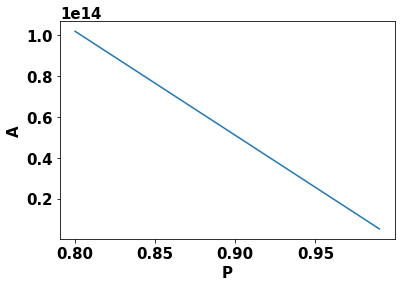

In [3]:
""" Plot the dead line """
P = np.linspace(0.8,0.99,128)
A = Abar*Nt*(1-P)

fig,ax = PP.subplots()
ax.plot(P,A)
ax.set_xlabel('P'); ax.set_ylabel('A')
PP.show()

# A more detailed constrainted, considering the latitude filter

The latitude filter effectively sets values near a band $\Delta y$ close to 0.  If we assume that all points within $2\Delta y$ of the equator are effectively removed from consideration, then the total number of points under considration $N_T$ should be reduced by the fraction $f$ of points that are taken out by the filter.

In the latitudinal direction, cell areas are only a function of latitude $y$ ($cos(y)$ specifically, so with the above assumption, $f$ can be approximated simply as:

$$ f = 1 - \frac{\int\limits_{-2\Delta y}^{2\Delta y} \cos(y)\,dy}{\int\limits_{-\pi/2}^{\pi/2} \cos(y)\,dy} = 1 - \sin(2\Delta y).$$

With this, the number of cells picked out by the filter will be approximately $N_c' = f \cdot N_t \cdot (1-P)$.  If we assume that there are typically at least 8 ARs at any given time, then there are typicaly at most $N_c'/8$ pixels per AR.  If we tighten the constraint to assert that these conditions should lead to ARs that typically have more than 1 pixel per AR, then this leads to a formulation of the dead-line that depends on the value of the latitude filter:

$$ A = \overline{A} \cdot (1 - \sin(2\Delta y)) \cdot \frac{ N_T \cdot (1-P)}{8}.$$

Alternatively, if we solve for $P$ as a function of $\Delta y$, we get a dead-curve in $\Delta y$-$P$ space:

$$ P = 1 - \frac{A}{\overline{A} \cdot (1 - \sin(2\Delta y)) \cdot N_T/8} $$

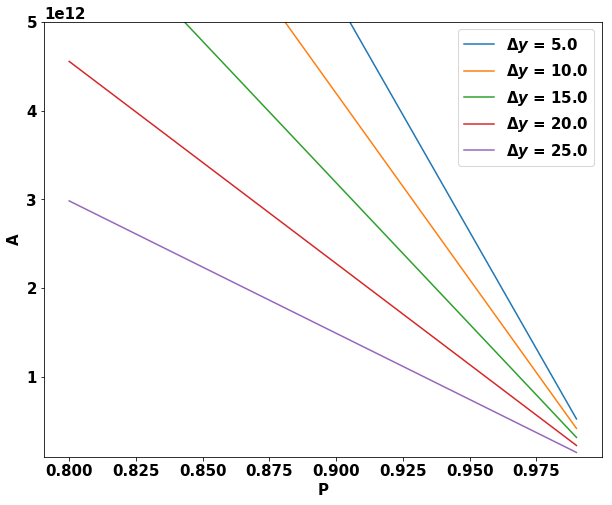

In [4]:
""" Plot the P-A space dead-line"""
P = np.linspace(0.8,0.99,128)
delta_y = np.linspace(5,25,5)

fig,ax = PP.subplots(figsize=(10,8))

for dy in delta_y:
    A = Abar*(1 - np.sin(2*dy*np.pi/180))*Nt/8*(1-P)

    ax.plot(P,A,label='$\Delta y$ = {:0.1f}'.format(dy))
    
ax.set_xlabel('P'); ax.set_ylabel('A')
ax.set_ylim([1e11,5e12])
ax.legend(loc='best')
PP.show()

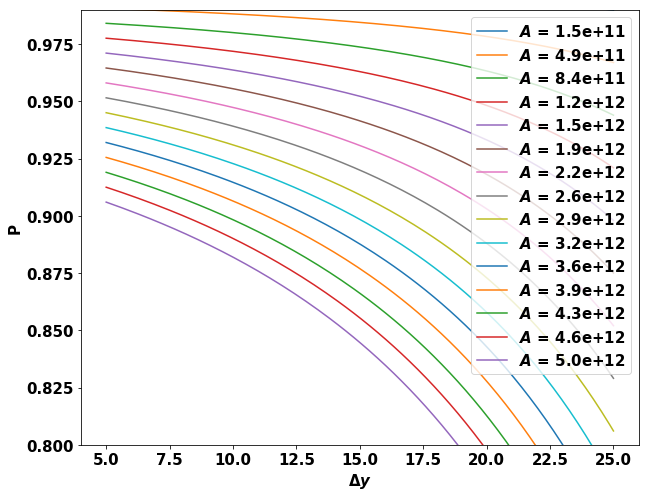

In [5]:
""" Plot the Dy-P space dead curve """
A_array = np.linspace(1e11,5e12,5)
A_array = [1.49e11,4.92e11,8.35e11,1.178e12,1.521e12,1.864e12,2.207e12,2.55e12,2.893e12,3.236e12,3.579e12,3.922e12,4.265e12,4.608e12,4.951e12]
delta_y = np.linspace(5,25,128)

fig,ax = PP.subplots(figsize=(10,8))

for A in A_array:
    P = 1 - A/(Abar*(1 - np.sin(2*delta_y*np.pi/180))*Nt/8)

    ax.plot(delta_y,P,label='$A$ = {:1.1e}'.format(A))
    
ax.set_xlabel(r'$\Delta y$'); ax.set_ylabel('P')
ax.legend(loc='best')
ax.set_ylim([0.8,0.99])
PP.show()

# Sampling from a prior with this constraint

Now that an a priori way to constrain the space of plausible parameters is established, a method for sampling within this constraint is needed.  Given that we are using a uniform prior for all parameters, the simplest way to implement this constraint would be through brute force.  Simply keep resampling until we have a full set of acceptable parameters.

In [22]:
""" Demonstrate a method for constrained uniform sampling via brute force. """
ndim = 3
nwalkers = 512

parameter_bounds = [ \
                    [0.8,0.99], \
                    [5, 25], \
                    [1e11, 5e12], \
                   ]

# Get initial parameter guesses
np.random.seed(0)
starting_guesses = np.zeros([nwalkers, ndim])
for bounds, n in zip(parameter_bounds, range(ndim)):
    starting_guesses[:,n] = np.random.uniform(low=bounds[0], high = bounds[1], size = nwalkers)
    
still_have_bad_values = True
while still_have_bad_values:
    Amax = Abar*(1 - np.sin(2*starting_guesses[:,1]*np.pi/180))*Nt/8*(1-starting_guesses[:,0])
    ibad = np.nonzero(starting_guesses[:,2] > Amax[:])[0]
    if len(ibad) == 0:
        still_have_bad_values = False
        break
    else:
        for bounds, n in zip(parameter_bounds, range(ndim)):
            new_guesses = np.random.uniform(low=bounds[0], high = bounds[1], size = len(ibad))
            starting_guesses[ibad,n] = new_guesses
                
Amax = Abar*(1 - np.sin(2*starting_guesses[:,1]*np.pi/180))*Nt/8*(1-starting_guesses[:,0])
ibad = np.nonzero(starting_guesses[:,2] > Amax[:])[0]
print(len(ibad))

0


/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/scipy/optimize/zeros.py:204: RuntimeWarning: Tolerance of -9.74505124852e-05 reached
  warnings.warn(msg, RuntimeWarning)
/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/scipy/optimize/zeros.py:204: RuntimeWarning: Tolerance of -9.23353066337e-05 reached
  warnings.warn(msg, RuntimeWarning)
/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/scipy/optimize/zeros.py:204: RuntimeWarning: Tolerance of -9.31237178219e-05 reached
  warnings.warn(msg, RuntimeWarning)


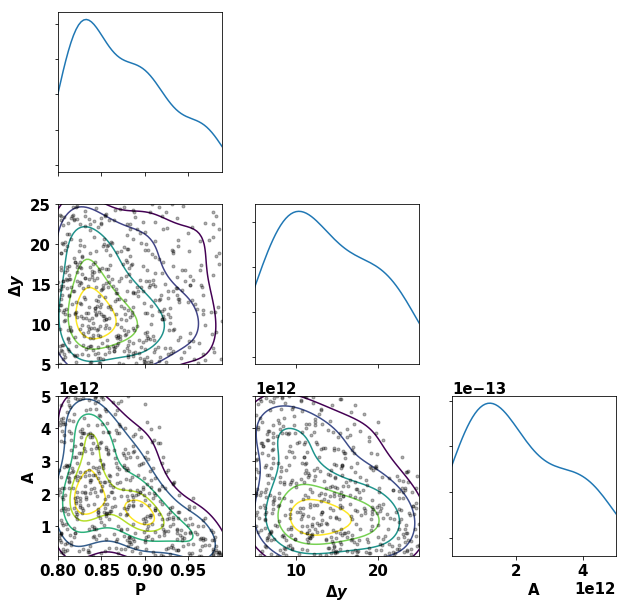

In [23]:
""" Draw a pair plot of the starting guesses """

fastkde.plot.pair_plot(starting_guesses.T,var_names=["P",r'$\Delta y$','A'])